In [1]:
import sys
sys.path.insert(1,"../src")
import tensorflow as tf
import nupack as n
import tensorflow.keras as tfk
from GA_util import create_ppms_fast
import numpy as np
from GA_util import GumbelSoftmax
import matplotlib.pyplot as plt
import util
import GA_util
import actmax
import pandas as pd
# print('loaded modules')

Metal device set to: Apple M1 Ultra


2025-03-18 17:22:22.735194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-18 17:22:22.735232: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2025-03-18 17:22:23.232633: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-03-18 17:22:23.232852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-18 17:22:23.263659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-18 17:22:23.309023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-03-18 17:22:23.349349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


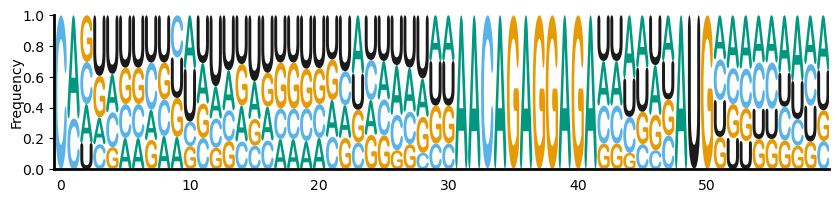

In [2]:
# latent_dim = 128

generator = tfk.models.load_model('../models/toehold_generator_2023-04-21')
tmp = generator(np.random.normal(size=(300,128)))
util.plot_logo(tmp[:,:,:,0])


In [7]:
sizes = [16,32,64,128,256]

for i in range(len(sizes)):
    
    
    
    predictor = tfk.models.load_model('../SANDSTORM/tmp_models/sandstorm_len_%i'%sizes[i])


    actmax_mod = actmax.ActMaxModel(generator,predictor)
    NSEQS = 2
    OUTPUT = 'ON'
    NSTEPS = 300
    STEP_SIZE = 0.1

    optimization = actmax.run_gan_opt_mult_seqs(actmax_mod,nseqs=NSEQS,output='on',n_steps=NSTEPS,step_size=STEP_SIZE)
    df = optimization[1]
    # df.to_csv('data/opt_exp_%s'%sizes[i])

Start Sequence 0
Start val:  0.19818312
Stop val:  0.39080998
iteration 0 took 7.58 seconds


Start Sequence 1
Start val:  0.19195192
Stop val:  0.56898487
iteration 1 took 7.55 seconds


Start Sequence 0
Start val:  0.2676597
Stop val:  0.5082321
iteration 0 took 7.76 seconds


Start Sequence 1
Start val:  0.20881937
Stop val:  0.94351035
iteration 1 took 7.77 seconds


Start Sequence 0
Start val:  0.78127885
Stop val:  1.2226408
iteration 0 took 7.79 seconds


Start Sequence 1
Start val:  0.3437603
Stop val:  1.1848202
iteration 1 took 8.03 seconds


Start Sequence 0
Start val:  0.7433146
Stop val:  0.94818705
iteration 0 took 8.01 seconds


Start Sequence 1
Start val:  0.6041298
Stop val:  1.170274
iteration 1 took 7.84 seconds


Start Sequence 0
Start val:  0.9314403
Stop val:  1.347678
iteration 0 took 8.14 seconds


Start Sequence 1
Start val:  0.27953488
Stop val:  1.1895663
iteration 1 took 7.68 seconds




In [ ]:
optimization_vecs = optimization[0]

0.10730809338390827


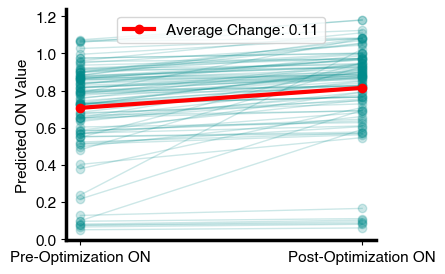

In [10]:
tick_1 = 0.25
tick_2 = 0.75

df = optimization[1]
# df = pd.read_csv('sequences/rbs_gardn_sandstorm_10_10_23.csv')

pre_mean = np.mean(df['Pre_Optimized_Value'])
post_mean = np.mean(df['Post_Optimized_Value'])
print(np.mean(df['Delta']))

plt.figure(figsize=(4,3))
plt.rcParams.update({'font.size': 11,'font.family':'Helvetica'})
plt.xticks(ticks=[tick_1,tick_2], labels=['Pre-Optimization ON','Post-Optimization ON'])
plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.subplot().spines['left'].set_linewidth(2.5)
plt.subplot().spines['bottom'].set_linewidth(2.5)
plt.ylabel('Predicted ON Value')
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.title('ON Value Optimization Results')
for i in range(df.shape[0]):
    plt.plot([tick_1,tick_2],[df.iloc[i,0],df.iloc[i,1]],color='darkcyan',alpha=0.2,marker='o',linewidth=1)
    
plt.plot([tick_1,tick_2],[pre_mean,post_mean],color='red',alpha=1,marker='o',linewidth=3,label='Average Change: %.2f'%(post_mean-pre_mean))
plt.legend()

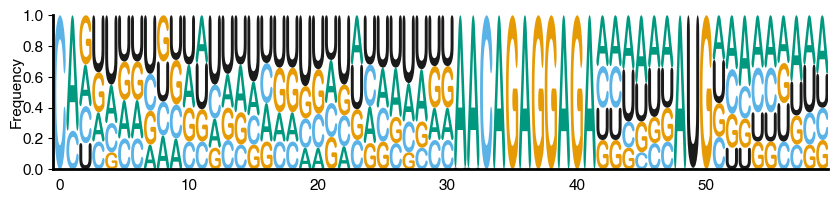

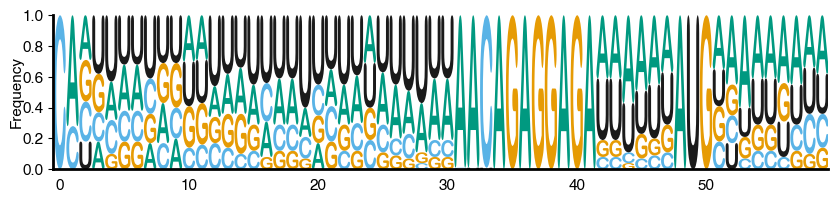

In [8]:
util.plot_logo(generator(optimization_vecs[:,:,0]))
util.plot_logo(generator(optimization_vecs[:,:,1]))

In [18]:
sizes = [16,32,64,128,256,512,1024,2048,4096]

master_pre_preds = np.zeros((len(sizes),len(sizes)))
master_post_preds = np.zeros((len(sizes),len(sizes)))

for i in range(len(sizes)):
    
    df = pd.read_csv('../data/sequence_experiments/opt_exp_%s'%sizes[i])
    predictor_cis = tfk.models.load_model('../SANDSTORM/tmp_models/sandstorm_size_%s'%sizes[i])
    
    
    pre_seqs = util.one_hot_encode(df[['Pre_Optimized_Sequence']])
    pre_ppms = GA_util.prototype_ppms_fast(pre_seqs)
    
    post_seqs = util.one_hot_encode(df[['Post_Optimized_Sequence']])
    post_ppms = GA_util.prototype_ppms_fast(post_seqs)
    
    for j in range(len(sizes)):
        
        predictor_trans = tfk.models.load_model('../SANDSTORM/tmp_models/sandstorm_size_%s'%sizes[j])
        
        pre_preds = predictor_trans.predict([pre_seqs,pre_ppms])
        pre_preds = np.mean(pre_preds)
        
        post_preds = predictor_trans.predict([post_seqs,post_ppms])
        post_preds = np.mean(post_preds)
        
        master_pre_preds[i,j] = pre_preds
        master_post_preds[i,j] = post_preds
    
    

2/4 [==============>...............] - ETA: 0s

2024-03-11 15:01:43.910037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 5ms/step


2024-03-11 15:01:44.600074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:01:45.311864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 5ms/step


2024-03-11 15:01:45.988574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:01:46.942966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:01:47.874166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:01:48.568540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:01:49.398416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 13ms/step


2024-03-11 15:01:50.662102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 25ms/step


2024-03-11 15:01:52.032821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


2024-03-11 15:01:52.770281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


2024-03-11 15:01:53.252798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 14ms/step


2024-03-11 15:01:53.728778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


2024-03-11 15:01:54.209043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 15ms/step


2024-03-11 15:01:54.674622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 16ms/step


2024-03-11 15:01:55.400624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step


2024-03-11 15:01:55.948551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 16ms/step


2024-03-11 15:01:56.673456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 4ms/step


2024-03-11 15:01:57.517417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 6ms/step


2024-03-11 15:01:58.093964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 5ms/step


2024-03-11 15:01:58.859228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 5ms/step


2024-03-11 15:01:59.393353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 6ms/step


2024-03-11 15:01:59.900672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:00.461856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:01.055169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 38ms/step


2024-03-11 15:02:01.713405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 35ms/step


2024-03-11 15:02:02.855174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 5ms/step


2024-03-11 15:02:03.885615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 5ms/step


2024-03-11 15:02:04.401800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 5ms/step


2024-03-11 15:02:04.971061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 6ms/step


2024-03-11 15:02:05.734419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:06.303178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 5ms/step


2024-03-11 15:02:06.895870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 8ms/step


2024-03-11 15:02:07.482715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:08.134140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:08.995204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 6ms/step


2024-03-11 15:02:10.265543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 5ms/step


2024-03-11 15:02:10.816309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:11.371244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 4ms/step


2024-03-11 15:02:11.939231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:12.492803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:13.347513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:13.942791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 40ms/step


2024-03-11 15:02:14.590714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:15.488737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:16.775081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 6ms/step


2024-03-11 15:02:17.347617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 6ms/step


2024-03-11 15:02:17.874221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 28ms/step


2024-03-11 15:02:18.436658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 7ms/step


2024-03-11 15:02:19.043915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:19.611167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 7ms/step


2024-03-11 15:02:20.475010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:21.100807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:21.949867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 30ms/step


2024-03-11 15:02:23.073754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:23.684517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 25ms/step


2024-03-11 15:02:24.515250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:25.124505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:25.705593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:26.293095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 28ms/step


2024-03-11 15:02:26.891870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 29ms/step


2024-03-11 15:02:27.797269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 38ms/step


2024-03-11 15:02:28.662948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 31ms/step


2024-03-11 15:02:29.805294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 30ms/step


2024-03-11 15:02:30.408280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 28ms/step


2024-03-11 15:02:31.026157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 30ms/step


2024-03-11 15:02:31.878401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 30ms/step


2024-03-11 15:02:32.483482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 29ms/step


2024-03-11 15:02:33.096791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 31ms/step


2024-03-11 15:02:33.713369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 34ms/step


2024-03-11 15:02:34.393434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 36ms/step


2024-03-11 15:02:35.516428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:36.776281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 26ms/step


2024-03-11 15:02:37.356289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 28ms/step


2024-03-11 15:02:37.948494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 33ms/step


2024-03-11 15:02:38.563383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 30ms/step


2024-03-11 15:02:39.423143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 30ms/step


2024-03-11 15:02:40.054233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 33ms/step


2024-03-11 15:02:40.720119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 29ms/step


2024-03-11 15:02:41.410491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 0s

2024-03-11 15:02:42.299908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 33ms/step


In [24]:
tmp =master_post_preds - master_pre_preds

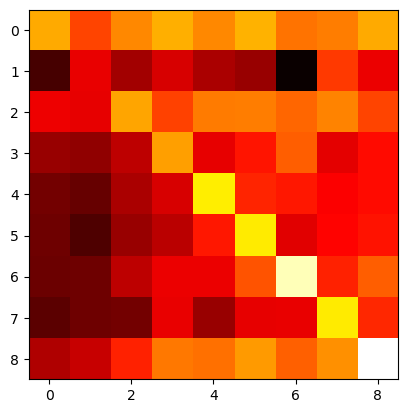

In [26]:
plt.imshow(tmp,cmap='hot')

In [73]:
sizes = [16,32,64,128,256,512,1024,2048,4096]

In [75]:
parameter_save = []

for size in sizes:
    mod = tfk.models.load_model('../SANDSTORM/tmp_models/sandstorm_size_%s'%size)
    
    params = np.sum([np.prod(v.get_shape()) for v in mod.trainable_weights])
    
    parameter_save.append(params)

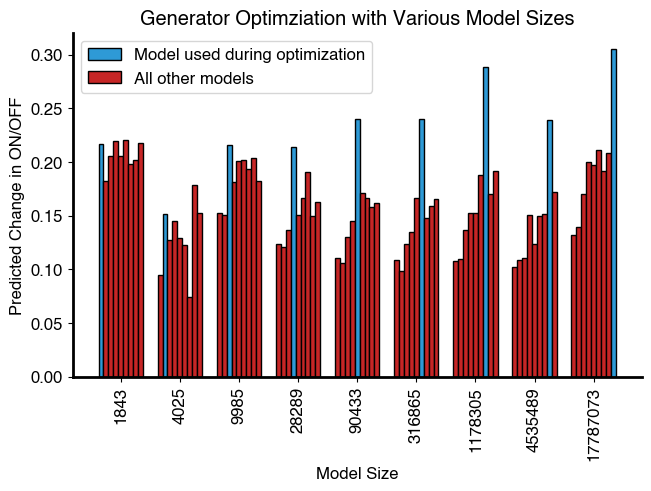

In [77]:
x = np.arange(0,tmp.shape[0]*12,12)  # the label locations

width = 1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for i in range(tmp.shape[0]):
    
    for j in range(tmp.shape[0]):
        
        if i ==j:
            COLOR = util.BLUE
        else:
            COLOR = util.RED
            
            
        plt.bar(x[i] + j,height=tmp[i,j],color=COLOR,width=1,edgecolor='black')
        
util.neat_plot()
plt.title('Generator Optimziation with Various Model Sizes')

tick_locs = np.arange(0,tmp.shape[0]*12,12) + 4

plt.xticks(tick_locs,labels=parameter_save,rotation=90)
plt.ylabel('Predicted Change in ON/OFF')
plt.legend(['Model used during optimization','All other models'])
plt.xlabel('Model Size')
plt.savefig('../figures/vary_predictor_optimization.svg',dpi=1000,transparent=True)
